<a href="https://colab.research.google.com/github/yebyyy/Reproduce-GPT2/blob/main/GPT2_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load GPT2 model

Load the GPT2 Transformer model through hugging face transformers

In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')  # Initializing the 124M model
sd_hf = model_hf.state_dict()  # Extracting the model parameters

for k, v in sd_hf.items():
    print(k, v.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 


```
transformer.wte.weight torch.Size([50257, 768])
```
wte means the weight for token embedding (the vocabulary), in other words the lookup table for tokens, has 50257 tokens in it and each of them has 768 dimension embedding.

```
transformer.wpe.weight torch.Size([1024, 768])
```
wpe is the look up table for positions, and GPT2 has a maximum sequence length of 1024, each of the positions are also encoded into a 768 dimensional embedding.

plot the positional embedding

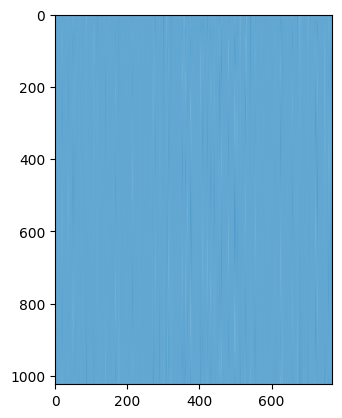

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="Blues")

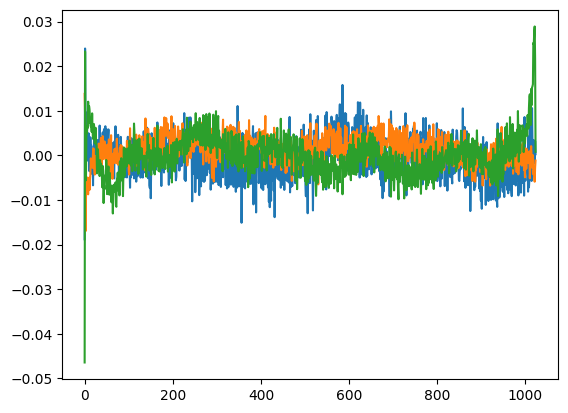

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 0])
plt.plot(sd_hf["transformer.wpe.weight"][:, 100])
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])

Not pretty smoothed out, meaning that the model isn't fully trained.

Note that the position embedding is initialized completely random, opposite of the original [Attention is all you need paper](https://arxiv.org/pdf/1706.03762), which has fixed positional embedding, OpenAI GPT2's positional embeddings are just trainable parameters.

In [ ]:
from transformers import pipeline, set_seed
set_seed(42)
generator = pipeline('text-generation', model="gpt2")
generator("Hello, I'm a Language Model,", max_length=30, num_return_sequences=5)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a Language Model, but what I'm really being warned about isn't that I'm writing something with any of that kind of power"},
 {'generated_text': 'Hello, I\'m a Language Model, not a Programmer!" and he says, "No, I\'ve done my job." Well, I guess'},
 {'generated_text': "Hello, I'm a Language Model, and I'll do it in no time!\n\nOne of the things we learned from speaking with my classmates"},
 {'generated_text': "Hello, I'm a Language Model, not a Programming Language, but you're not my code.\n\nI was wondering if the concept could be"},
 {'generated_text': "Hello, I'm a Language Model, I've been using Language Models all my life. This is my first time building a language model, and it"}]

### Section 1: class GPT(nn.modules)

Two major differences GPT 2 and the decoder from the original Transformer paper:
- Layer Norm before going through feed forward and self attention
- Additional Final Layer Norm added before going outside the block

We try to implement this class in a similar schema to the huggingface gpt2 that has a dict of parameters since its easier to load the weigths.

We apply the layer norm before going to the self attention block instead of applying the layer norm after the self attention because it makes the residual connection clearner

#### Gelu Activation in the FFN(FeedForward Net)

Gelu comes from the paper [GAUSSIAN ERROR LINEAR UNITS (GELUS)](https://arxiv.org/pdf/1606.08415)

It is similar to relu but changed the sharp turn at x = 0 to a smoother change. It is also smoother at the other y = 0 places so that unlike relu, which would create dead neurons, gelu will always let the gradient flow through.

The original GPT2 used the tanh approximate version of Gelu, and we stick with that, however in reality there is no need to do that any more.

#### Training

In [ ]:
with open("input.txt", "r") as file:
    text = file.read()

In [ ]:
data = text[:1000]
data

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.8 MB/s eta 0:00:00


In [ ]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)

In [ ]:
tokens[:24]

[5962,
 22307,
 25,
 198,
 8421,
 356,
 5120,
 597,
 2252,
 11,
 3285,
 502,
 2740,
 13,
 198,
 198,
 3237,
 25,
 198,
 5248,
 461,
 11,
 2740,
 13]

How to change these tokens to (B, T) input tensors?

Similar to the Shakespear project:

In [ ]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
x, y

(tensor([[ 5962, 22307,    25,   198,  8421,   356],
         [ 5120,   597,  2252,    11,  3285,   502],
         [ 2740,    13,   198,   198,  3237,    25],
         [  198,  5248,   461,    11,  2740,    13]]),
 tensor([[22307,    25,   198,  8421,   356,  5120],
         [  597,  2252,    11,  3285,   502,  2740],
         [   13,   198,   198,  3237,    25,   198],
         [ 5248,   461,    11,  2740,    13,   198]]))

Training in batches using the shakespear data set: loss won't go down too much since there are 50257 tokens, and whole lot of tokens didn't get used, and the model is basically dragging those possibilities to 0

#### Parameter sharing wte and lm_head

In [ ]:
if sd_hf["transformer.wte.weight"].shape == sd_hf["lm_head.weight"].shape:
  print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])


In [ ]:
(sd_hf["transformer.wte.weight"] == sd_hf["lm_head.weight"]).all()

tensor(True)

In [ ]:
sd_hf["lm_head.weight"].data_ptr() == sd_hf["transformer.wte.weight"].data_ptr()

True

This means that all the things inside the token embeddings and the output linear layer is the same

This is also explained in the "Attention is All You Need" paper

We want these two things to behave similar for the following reasons:
- If two tokens are similar, they would be near each other in the token embedding space, and you would expect they have similar prob in the output since they are semantically similar.

Thus in the backward pass, we will have both the gradients flowing to the wte and they add up

Sharing the parameters also helps with the model such that we can train with less resources

#### GPT2 Initialization

In the original code, they used the std = 0.02 for weights and bias and mean = 0

Generally by He Initialization and other initialization, we divide by 1/(input^2). Since the d_model(n_embd) in the GPT2 paper is 768 for the 124M model and up to 1600 for bigger models, 0.02 is roughly correct because 1/768^2 = 0.036, and 1/1600^2 = 0.025

Other than the training parameters from the Self Attention and the FFW layer, we also need to initialize the parameters in the residual layers

In the GPT2 paper, we scale the weights inside the residual layers with factor 1/N^0.5 where N is the # of the residual layers

In [ ]:
x = torch.zeros(768)
n = 100
for i in range(n):
  x += torch.randn(768)
x.mean(), x.std()

(tensor(0.5719), tensor(9.8469))

This example shows that the activations in the residual stream grows

In [ ]:
x = torch.zeros(768)
n = 100
for i in range(n):
  x += 1 / (n ** 0.5) * torch.randn(768)
x.mean(), x.std()

(tensor(0.0142), tensor(0.9665))

After normalizing using the square root of n, the std returns to normal

When scaling the residual layers in a transformer model like GPT-2, the goal is to normalize the contribution of different layers to the final output.

Thus, to do this, we can normalize the self.cproj layers since they are the last layers before output for each block

### Section 2: Speed up

[Recommended GPU Compute](https://lambdalabs.com/)

We use this line to find out that the logits and loss are all of data type `torch.float32`, which are too precise.

In [ ]:
import code; code.interact(local=locals())

For DL, NNs can usually tolerate a very low precision in terms of data

[Nvidia A100 Tensor Core Specifications](https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf)

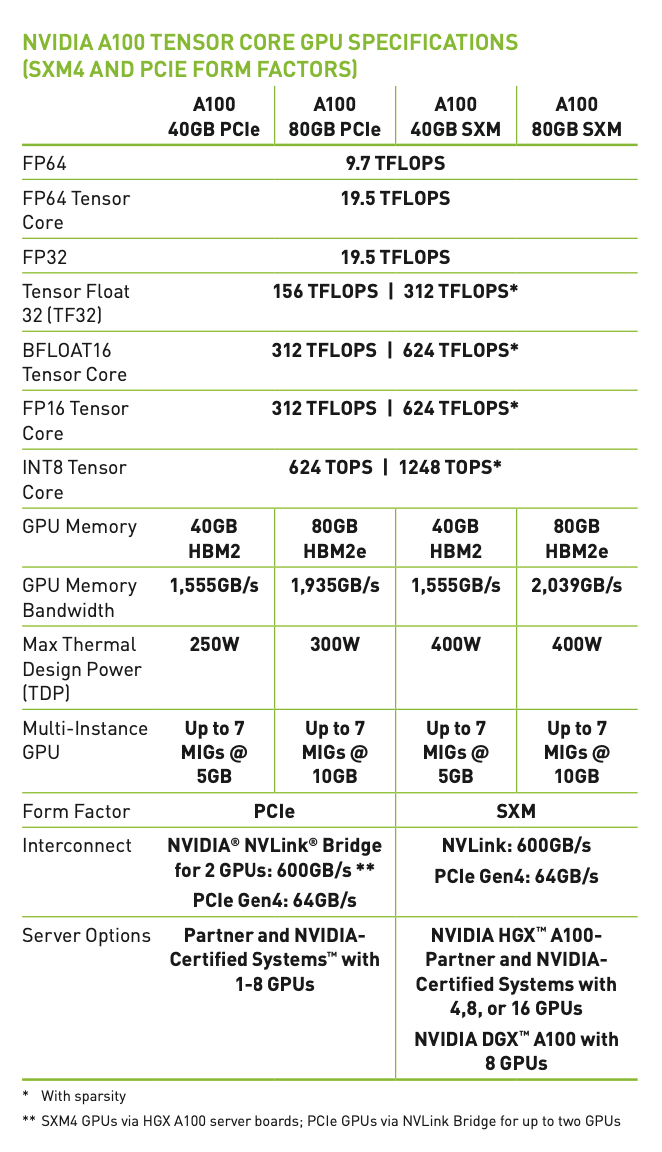

From the sheet we found that the compute for Float32 is 19.5 TFlops, which is 19.5 trillion float point operations.

Notice also that when we go down the list, decreasing the precision will give up to and around 16x performance

If we bring down the precision, it is a lot easier to move things around, faster to retrieve

GPU Bandwidth: speed to access GPU memory, and actually a lot of limitations comes from this part that we are not fast enough to access GPU memory to feed into the tensor cores

#### Tensor cores, FP32 -> TF32 -> (FP16) -> BF16

Tensor Cores are designed to perform matrix multiplications and accumulate the results (often referred to as fused multiply-add operations) very efficiently.

Tensor cores gives instructions on how to handles data types as well.

From [Nvidia A100 Achitecture](https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf) we have this pic

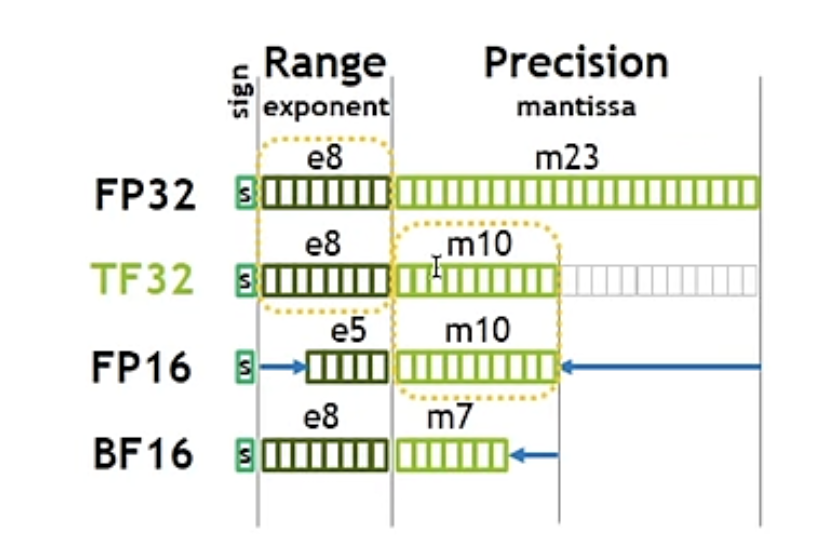

For Float32, Tensor cores use TF32, which drops the last 13bits, in order to get 8x faster

When timing GPU, we need to use the following code to let the GPU to actually finish the work assigned from the CPU and then time it.

In [ ]:
import time

In [ ]:
torch.cuda.synchronize()

We also use the following code to watch the usage of GPU

In [ ]:
!watch -n 0.1 nvidia-smi

This is the result we get from the training

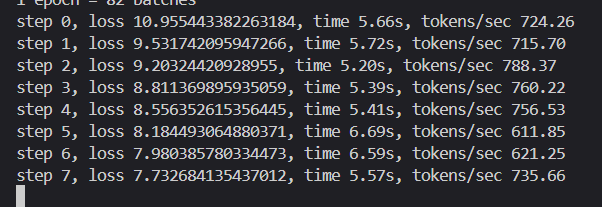

Use the following line to enable TF32, and documents can be seen [here](https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html)

In [ ]:
torch.set_float32_matmul_precision('high')

After this code, we get the following result:

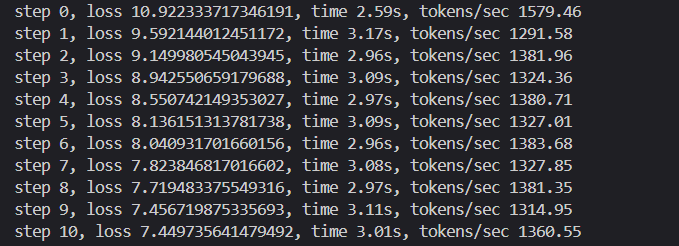

Instead of 8x, we get a 2x improvement, and the reason is still memory bound since we are still shipping and moving the float32 datas around

Now we do BF16, it is also 16bits but better than FP16 since we are keeping the range and truncating the precision

For FP16, we need to do a lot of extra stuff like gradient scaling etc, because we loses information in the range.

[Pytorch Automatic Mixed Precision](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html#automatic-mixed-precision) and look at `torch.autocast` and only enable it at the forward pass and the loss calculation.

In [ ]:
with torch.autocast(device_type = device, dtype = torch.bfloat16):
  logits, loss = model(x, y)

NameError: name 'torch' is not defined

However, we still have this mixed precision because our model parameters are still treated as fp32 by pytorch. Most matrix multiplication stuff converts, but normalizations and a lot of other calculations remains unchanged.

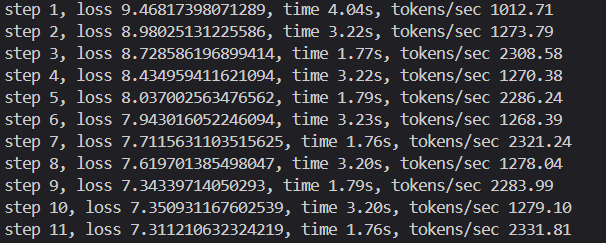

We can see some improvements.

#### `torch.compile`

After shipping the model to the device and before the forward loop:

In [ ]:
model = torch.compile(model)

NameError: name 'torch' is not defined

This speedup mainly comes from reducing python overhead and GPU read/writes

This gives around 2x improvement to the model

Python interpreter doesn't know what is going to happen later, but `torch.compile` sees the entire code at the same time, know what operations you intend to run, and it will optimize the process.

`torch.compile` will do the following things:
1. Take out the python interpreter from the forward pass and compile the entire NN as a single object
2. Reduce unnecessary GPU read and write

In [ ]:
class TanhGELU(nn.Module):
  def forward(self, x):
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

For example, in this code, python interpreter will first store torch.pow(x, 3.0) to High Bandwidth Memory (HBM), which is like the RAM for the GPU, and it need to go to the GPU to do the computation and then go back to HBM.

However, traveling back and forth the memory is very expensive, and then we still need to port it back and then do the multiplication and then save the result back etc etc etc.

`torch.compile` notices that all are element wise computations, so it just ports everything to the GPU once and does all the computations and then come back

This is also an example of **kernel fusion**, which is to combine multiple GPU kernel operations into a single kernel

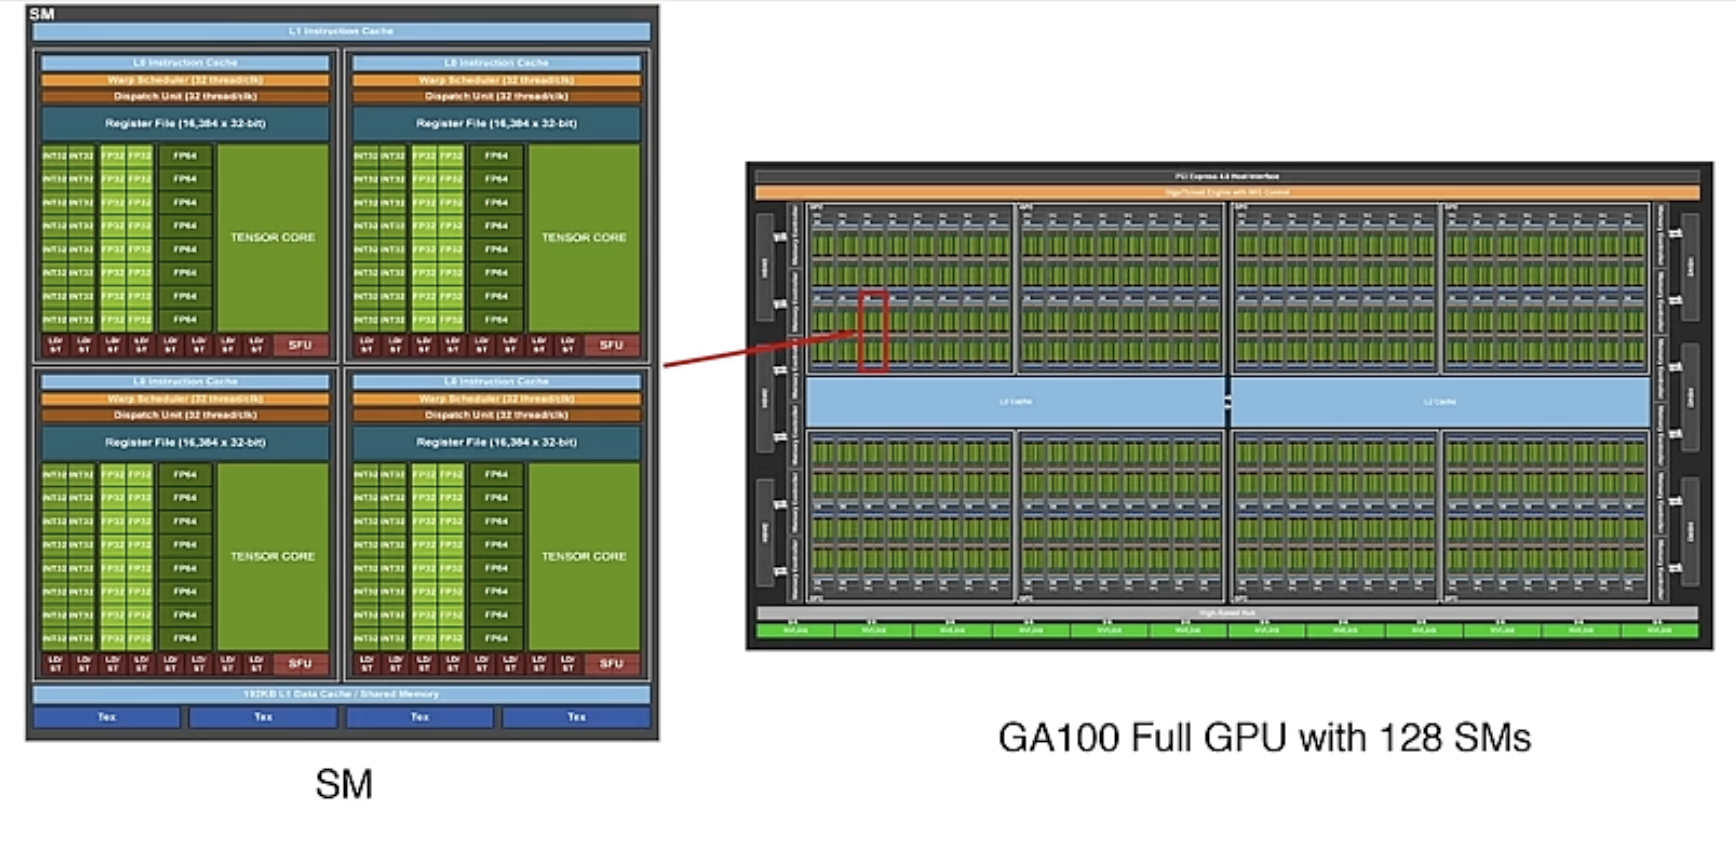

GPU has L2 cache and SM has Register and L1 cache for memory but they are very limited storage

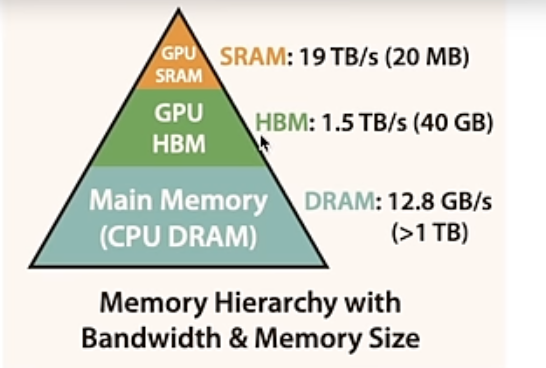

This figure shows that the HBM and CPU are extremely expensive to read and write, and GPU itself has very limited storage but very fast access rate

#### Flash Attention

Flash Attention comes from [FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness](https://arxiv.org/pdf/2205.14135) and [FlashAttention-2:
Faster Attention with Better Parallelism and Work Partitioning](https://arxiv.org/pdf/2307.08691)

Flash Attention is a kernel fusion operation

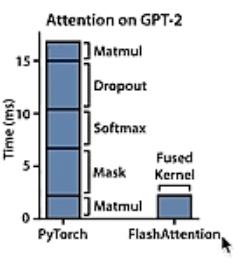

This is the original code without the dropout in the GPT2 model

In [ ]:
att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
att = F.softmax(att, dim=-1)  # attention as probabilities of each token
y = att @ v

Flash Attention actually does more flops than the implementation above, but it is theoretically 7.6x faster. This is because it is very mindful of the memory hierarchy, and we will have fewer read and writes to the HBM, and `torch.compile` can't do this because it would require rewriting the algo

Flash Attention makes sure that the attention matrix(att) never gets materialize and read and written to the HBM.

This is achieved through a online softmax trick, which doesn't require all the input of the softmax to be realized to do the normalization

This online softmax comes from [Online Normalization for Training Neural Networks](https://arxiv.org/pdf/1905.05894)

And Flash Attention fuses the online softmax and all the other operations into a single kernel

Thus, we can use the following code to replace the original our implementation of the attention

In [ ]:
y = F.scaled_dot_product_attention(q, k, v, is_casual=True)

We now have achieved a very fast result

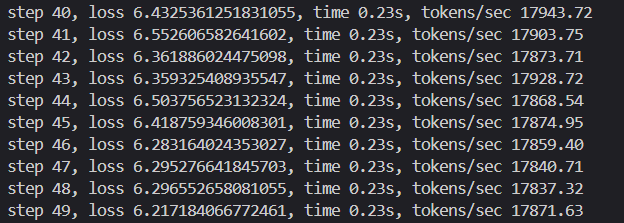